# SAE Feature Clustering

This code performs the SAE feature clustering for bias computation as described in Section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tabulate import tabulate
import torch
import matplotlib.pyplot as plt
import numpy as np
import json
import sklearn
import umap
import hdbscan
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

In [ ]:
def extract_description(model_id, layer, index, json_data):
    index_str = str(index)

    if index_str in json_data:
        return json_data[index_str]

    return "Description not found"

In [ ]:
# Load the JSON data from file
file_path = "./drive/MyDrive/dedicated_WAM/data/gemma-2-2b_25-gemmascope-res-16k.json"

with open(file_path, "r") as f:
    json_data = json.load(f)

# Convert the JSON dictionary into a DataFrame
df_features = pd.DataFrame(json_data, columns=["Index", "Description"])

# Display DataFrame structure
print("DataFrame columns:", df_features.columns)
print(df_features.head())

# Check if the DataFrame is empty
if df_features.empty:
    print("No entries found for the given model and layer. Check the values.")
else:
    # Rename "Index" to "feature" for clarity
    df_features.rename(columns={"Index": "Feature"}, inplace=True)

    # Convert the "feature" column to integer
    df_features["Feature"] = df_features["Feature"].astype(int)

    # Sort the DataFrame by the feature number
    df_features.sort_values("Feature", inplace=True)
    df_features.reset_index(drop=True, inplace=True)

    # Display the first few rows to verify the content
    print(df_features.head())

    # Save the DataFrame to CSV for later use
    df_features.to_csv("all_features.csv", index=False)

In [ ]:
data = df_features[['Feature', 'Description']].to_dict(orient="records")
for entry in data[:5]:
    print(entry)

{'Feature': 0, 'Description': ' proper nouns, particularly names and organizations'}
{'Feature': 1, 'Description': ' numeric values and references to measurements or levels'}
{'Feature': 2, 'Description': 'specific geographic locations and judicial references'}
{'Feature': 3, 'Description': "references to the letter 'K'"}
{'Feature': 4, 'Description': ' programming code snippets and structure'}


In [ ]:
df_data = pd.DataFrame(data)
df_data.head()

,Feature,Description
0,0,"proper nouns, particularly names and organiza..."
1,1,numeric values and references to measurements...
2,2,specific geographic locations and judicial ref...
3,3,references to the letter 'K'
4,4,programming code snippets and structure


In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df_data['Description'].tolist(), convert_to_numpy=True)

reducer = umap.UMAP(n_components=100, n_neighbors=50, metric="cosine", random_state=42)
embeddings_reduced_umap = reducer.fit_transform(embeddings)

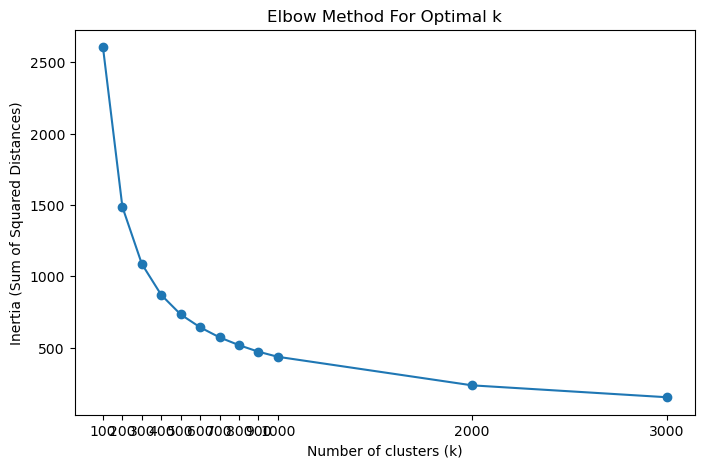

In [ ]:
k_values = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000]

inertias = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings_reduced_umap)
    inertias.append(kmeans.inertia_)

# Plot the elbow graph using the given list of k values
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method For Optimal k")
plt.xticks(k_values)
plt.show()


Saved sorted clusters to 'clustered_features_sorted_k1000.csv' ✅

Cluster Summary:
     cluster  num_features
0          0            21
1          1            16
2          2            25
3          3            25
4          4             8
..       ...           ...
995      995            39
996      996            27
997      997            39
998      998            14
999      999            32

[1000 rows x 2 columns]


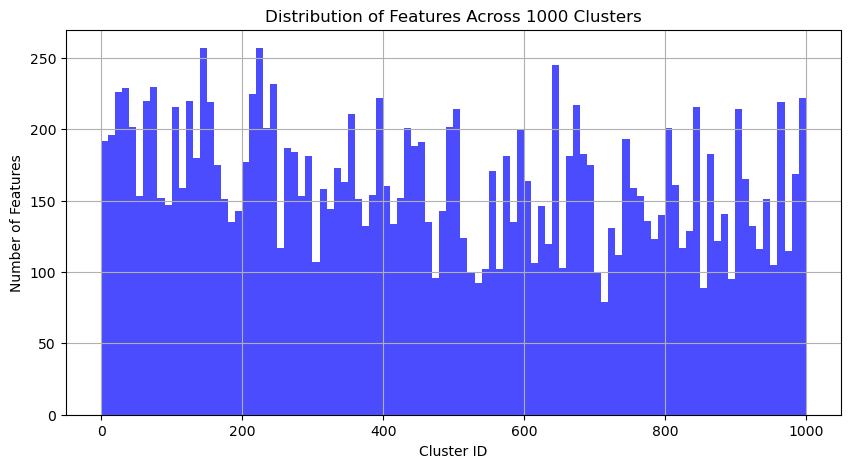

In [ ]:
# Run KMeans with k=1000
optimal_k = 1000
kmeans = MiniBatchKMeans(n_clusters=optimal_k, batch_size=1024, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(embeddings_reduced_umap)

# Assign clusters and sort by cluster
df_data['cluster'] = clusters
df_data_sorted = df_data.sort_values(by="cluster").reset_index(drop=True)

# Save sorted data to CSV
df_data_sorted.to_csv("clustered_features_sorted_k1000.csv", index=False)
print("Saved sorted clusters to 'clustered_features_sorted_k1000.csv'")

# Display Cluster Summary
cluster_summary = df_data_sorted.groupby('cluster').size().reset_index(name="num_features")
print("\nCluster Summary:")
print(cluster_summary)

# Plot Cluster Distribution
plt.figure(figsize=(10, 5))
plt.hist(df_data_sorted['cluster'], bins=100, alpha=0.7, color='blue')
plt.xlabel("Cluster ID")
plt.ylabel("Number of Features")
plt.title("Distribution of Features Across 1000 Clusters")
plt.grid()
plt.show()

In [ ]:
df_data_sorted.head(10)

,Feature,Description,cluster
0,11013,references to health conditions and their impa...,0
1,13605,phrases related to significant events or stati...,0
2,15913,the significance of key phrases and descriptor...,0
3,4384,"references to health-related topics, particula...",0
4,7786,references to health-related topics or issues,0
5,12363,concepts related to health issues and their i...,0
6,9124,significant implications and consequences rela...,0
7,9159,references to the character Dar and mentions o...,0
8,12035,topics related to public health disparities a...,0
9,14876,"issues related to public health crises, parti...",0


### Get cluster labels

In [ ]:
import google.generativeai as genai
import os
import google.generativeai as genai
import pandas as pd
import re
import random
import time

In [ ]:
# Load the previously saved DataFrame
df_data_sorted = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Term 2/NLP/clustered_features_sorted_k1000.csv")

print(df_data_sorted.head())

   Feature                                        Description  cluster
0    11013  references to health conditions and their impa...        0
1    13605  phrases related to significant events or stati...        0
2    15913  the significance of key phrases and descriptor...        0
3     4384  references to health-related topics, particula...        0
4     7786      references to health-related topics or issues        0


In [ ]:
!pip install google-generativeai --upgrade

In [ ]:
# insert api key
api_key = ""
genai.configure(api_key=api_key)

MODEL_NAME = "gemini-1.5-flash"
model = genai.GenerativeModel(MODEL_NAME)

In [ ]:
def clean_generated_label(text):
    """Cleans and trims the generated label to ensure it's short and well-formatted."""
    text = text.strip()
    text = re.sub(r'\n+', ' ', text)  # Remove excessive new lines
    text = re.sub(r'^\W+|\W+$', '', text)  # Remove special characters
    words = text.split()
    if len(words) > 6:
        text = ' '.join(words[:6])  # Trim to 6 words max
    return text


def label_cluster(descriptions, retries=3):
    """Generates a concise and meaningful title for a feature cluster using Gemini AI."""

    prompt_text = "Below are descriptions of features from a related topic cluster:\n\n"
    for i, d in enumerate(descriptions, start=1):
        prompt_text += f"{i}) {d}\n"

    prompt_text += (
        "\nGenerate a short and meaningful category title (3-6 words) summarizing this cluster."
        " The title should clearly represent the main topic without extra words."
        " Respond with only the title—no explanations."
        "\n\nTitle: "
    )

    attempt = 1
    while attempt <= retries:
        try:
            response = model.generate_content(prompt_text)
            generated_text = response.text.strip()
            return clean_generated_label(generated_text)

        except Exception as e:
            print(f"Gemini AI Error (Attempt {attempt}/{retries}): {e}")

            if "429" in str(e):  # If hitting rate limits, add an exponential backoff
                sleep_time = random.uniform(20, 60) * attempt  # Increase delay with each attempt
                print(f"Rate limit hit! Pausing for {sleep_time:.1f} seconds before retry...")
                time.sleep(sleep_time)
            else:
                break  # If it's another error, don't retry

        attempt += 1

    return "General"

cluster_ids = df_data_sorted["cluster"].unique()
cluster_labels = {}

batch_size = 15
total_batches = len(cluster_ids) // batch_size + 1

for batch_num in range(total_batches):
    batch_clusters = cluster_ids[batch_num * batch_size: (batch_num + 1) * batch_size]
    print(f"\nProcessing batch {batch_num + 1}/{total_batches} ({len(batch_clusters)} clusters)")

    for i, cid in enumerate(batch_clusters, start=1):
        cluster_data = df_data_sorted[df_data_sorted["cluster"] == cid]["Description"]
        samples = cluster_data.sample(min(10, len(cluster_data)), replace=False).tolist()

        # Generate the Cluster Title
        label = label_cluster(samples)
        cleaned_label = clean_generated_label(label)

        # Fixing Bad Outputs
        if cleaned_label in ["Unknown", "", "1", "Between"]:
            print(f"Warning: Bad label for cluster {cid}. Assigning 'General'.")
            cleaned_label = "General"

        cluster_labels[cid] = cleaned_label

    # Save Backup After Each Batch
    df_cluster_labels = pd.DataFrame(list(cluster_labels.items()), columns=["Cluster ID", "Cluster Label"])
    df_cluster_labels.to_csv("cluster_labels_backup.csv", index=False)
    print(f"💾 Saved backup (Processed {len(batch_clusters)} clusters)")

    # Adaptive Delay Before Next Batch
    pause_time = random.uniform(30, 90)
    print(f" Pausing for {pause_time:.1f} seconds before the next batch...")
    time.sleep(pause_time)

# Save Final Results
df_cluster_labels.to_csv("cluster_labels_fixed.csv", index=False)
print("\nCluster labels saved to 'cluster_labels_fixed.csv' ")
